In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
def TD_CC_TSB(A, n, alpha, delta):
    # A is the data matrix, n=1 did nothing
    # alpha is in the paper, delta is just a small number.
    n_bicluster = []
    # the for loop need to be removed, since it did nothing. But it will the return data structure, which will impact 
    # the function residualScoreCol_add.
    for i in range (0, n):
        num_features = A.shape[0]
        num_time_points = A.shape[1]
        
        # I and J are the index holder of the data matrix.
        I = list(np.arange(0,num_features))
        J = list(np.arange(0,num_time_points))
        H = residualScore(A, I, J)
        #intial temp_H and H
        temp_H = 0
        H = 10000
        #print "deletion process"
        while abs(H - temp_H) > delta:
            temp_H = H
            I = delelteRow(A, I, J, H, alpha)
            H = residualScore(A, I, J)
            #print "Hrow", H
            J = delelteCol(A, I, J, H, alpha)
            H = residualScore(A, I, J)
            
            #print "Hcol", H
        #print "Insertion process"
        insert = True
        while insert == True:
            I_before = len(I)
            J_before = len(J)
            #print "rows before start insertion", I
            #print "columns before start insertion", J
            J = insertCol(A, I, J, H,alpha)
            H = residualScore(A, I, J)
            I = insertRow(A, I, J, H,alpha)
            H = residualScore(A, I, J)
            I_after = len(I)
            J_after = len(J)
            #print "the length of rows after insertion", I_after
            #print "the length of columns after insertion", J_after
            if (I_before == I_after) and (J_before == J_after):
                insert = False

        # store the bicluster index
        n_bicluster.append([i, I, J])

    return n_bicluster


def delelteRow(A, I, J, H, alpha):
    for i in I:
        H_row = residualScoreRow_del(A, I, J, i)
        #print i, "row score", H_row
        ratio = 1./H*H_row
        #print "H score is", H
        #print "Ri ratio is", ratio
        if ratio > alpha:
            I.remove(i)
    #print "currently rows after deleting rows", I
    return I


def delelteCol(A, I, J, H, alpha):
    J_prime = [min(J), max(J)]
    for j in J_prime:
        H_col = residualScoreCol_del(A, I, J, j)
        ratio = 1./H*H_col
        #print j, "column socre", H_col
        #print "H score is", H
        #print "Rj ratio is", ratio
        if ratio > alpha:
            J.remove(j)
    #print "currently columns after deleting column",J
    return J

def insertCol(A, I, J, H,alpha):
    J_prime = [min(J)-1, max(J)+1]
    for j in J_prime:

        if (j >= A.shape[1]) or (j < 0):
            return J
        else:
            H_col = residualScoreCol_add(A, I, J, j)
            #print "column for insertion", j
            ratio = 1./H*H_col
            #print "column socore", H_col
            #print "Rj ration", ratio
            if ratio < alpha:
                J.append(j)
            #print "currently columns after inserting column",J
            return J


def insertRow(A, I, J, H,alpha):
    num_features = A.shape[0]
    full_I = list(np.arange(0,num_features))
    for i in full_I:
        if i not in I:
            H_row = residualScoreRow_add(A, I, J, i)
            ratio = 1./H*H_row
            #print i, "row score", H_row
            #print "Ri ratio", ratio
            if ratio < alpha:
                I.append(i)
    #print "currently rows after inserting rows",I
    return I



def residualScore(A, I, J):
    I.sort()
    J.sort()
    # get sub matrix based on index holder I(row) and J(column)
    sub_A = A[np.ix_(I,J)]
    # sub matrix mean
    a_I_J = sub_A.mean()
    temp = 0
    # loop the row of submatrix
    for i_sub in range (0, sub_A.shape[0]):
        a_i_J = sub_A.mean(1)[i_sub,0]
        # loop the column of the submatrix
        for j_sub in range(0, sub_A.shape[1]):
            a_i_j = sub_A[i_sub,j_sub]
            a_I_j = sub_A.mean(0)[0,j_sub]
            temp += (a_i_j - a_i_J - a_I_j + a_I_J)**2
    I_num = len(I)
    J_num = len(J)
    H = 1./(I_num*J_num)*temp
    return H


def residualScoreRow_del(A, I, J, i):
    I.sort()
    J.sort()
    # get row index of submatrix, which is the row i in full matrix
    i_sub = I.index(i)
    sub_A = A[np.ix_(I,J)]
    a_I_J = sub_A.mean()
    a_i_J = sub_A.mean(1)[i_sub,0]
    temp = 0
    for j_sub in range(0, len(J)):
        a_i_j = sub_A[i_sub,j_sub]
        a_I_j = sub_A.mean(0)[0,j_sub]
        temp += (a_i_j - a_i_J - a_I_j + a_I_J)**2
    J_num = len(J)
    H_row = 1./J_num*temp
    return H_row


def residualScoreCol_del(A, I, J, j):
    I.sort()
    J.sort()
    # get column index of submatrix, which is the column j in full matrix
    j_sub = J.index(j)
    sub_A = A[np.ix_(I,J)]
    a_I_J = sub_A.mean()
    a_I_j = sub_A.mean(0)[0,j_sub]
    temp = 0
    for i_sub in range (0, len(I)):
        a_i_J = sub_A.mean(1)[i_sub,0]
        a_i_j = sub_A[i_sub,j_sub]
        temp += (a_i_j - a_i_J - a_I_j + a_I_J)**2
    I_num = len(I)
    H_column = 1./(I_num)*temp

    return H_column

def residualScoreRow_add(A, I, J, i):
    I.sort()
    J.sort()
    i_sub = len(I)
    sub_A = A[np.ix_(I,J)]
    a_I_J = sub_A.mean()
    I_add = list(I)
    I_add.append(i)
    sub_A_add = A[np.ix_(I_add,J)]

    a_i_J = sub_A_add.mean(1)[i_sub,0]
    temp = 0
    for j_sub in range(0, len(J)):
        a_i_j = sub_A_add[i_sub,j_sub]
        a_I_j = sub_A.mean(0)[0,j_sub]
        temp += (a_i_j - a_i_J - a_I_j + a_I_J)**2
    J_num = len(J)
    H_row = 1./J_num*temp
    return H_row


def residualScoreCol_add(A, I, J, j):
    I.sort()
    J.sort()
    sub_A = A[np.ix_(I,J)]
    a_I_J = sub_A.mean()
    j_sub = len(J)
    J_add = list(J)
    J_add.append(j)
    sub_A_add = A[np.ix_(I,J_add)]
    a_I_j = sub_A_add.mean(0)[0,j_sub]
    temp = 0
    for i_sub in range (0, len(I)):
        a_i_J = sub_A.mean(1)[i_sub,0]
        a_i_j = sub_A_add[i_sub,j_sub]
        temp += (a_i_j - a_i_J - a_I_j + a_I_J)**2
    I_num = len(I)
    H_column = 1./(I_num)*temp

    return H_column

def bicluster_out(ret_tran, datatype = 'stock'):
    
    # filein is the file path and name. 
    # fileindate is the date read from stockdatelist. In this setup, it is easier to loop over all file with date as variable.
    
#     filein = 'stockreturn1min'+str(fileindate)+'.csv'
#     f = pd.read_csv (filein)
#     data_folder = 'data example/'
#     filein = data_folder + 'stockreturn1min' + fileindate +'.csv'
#     f = pd.read_csv (filein)
    
#     ret = f.drop(['date','time'], axis=1)
#     ret = ret.set_index('KEY1')
#     ret_tran = ret.transpose()
    A = ret_tran.values
    a = np.asmatrix(A)
    a1 = a.copy()
    num_stock_explained = 0
    # number of bicluster
    i = 0
    temp = 100
    # here is 80 is the beta in our paper
    while (num_stock_explained < 80):
        result = TD_CC_TSB(a1, 1, alpha= 1.2, delta= 1e-12)
        I = result[0][1]
        temp = len(I)
        num_stock_explained += temp
        J = result[0][2]

        # if there is new biclucter identified.
        if len(I) > 1:
            ff =ret_tran.iloc[I,J]
            ee = ret_tran.iloc[I,:]
            i += 1
            # output the identified new bicluster
#             outfile = str(fileindate)+'_'+'bicluster'+str(i)+'.csv'
            
            if datatype == 'stock':
                outfile = 'results/20130102_'+'bicluster'+str(i)+'.csv'
                
            if datatype == 'energy':
                outfile = 'results/energy_'+'bicluster'+str(i)+'.csv'
            
            ff.index = ff.index.astype(str)
            ff.to_csv(outfile, index=True)
            
            # Eliminate all the identified biclusters from the orignal data matrix
            ret_tran = ret_tran[~ret_tran.isin(ee).all(1)]
            A = ret_tran.values
            a = np.asmatrix(A)
            a1 = a.copy()
        else:
            break
    return i, num_stock_explained


In [3]:
# # read the date list
# tradingdayList_full = pd.read_csv ('stockdatelist.csv')
# tradingdayList_full = list(tradingdayList_full.date.unique())
# date_bicluster = []
# # loop over the all the date
# for e in tradingdayList_full:
#     n, num = bicluster_out(e)
#     # record the date (e), the number of identifed biclusters (n), and the number of the stock explained (num)
#     date_bicluster.append([e, n, num])
    
# bic = pd.DataFrame(date_bicluster)
# # output the file recording the the date (e), the number of identifed biclusters (n), and the number of the stock explained (num)
# bic.to_csv('date_bicluster.csv')


data_folder = 'data example/'
filein = data_folder + 'stockreturn1min' + '20130102' +'.csv'
f = pd.read_csv (filein)

ret = f.drop(['date','time'], axis=1)
ret = ret.set_index('KEY1')
ret_tran = ret.transpose()


date_bicluster = []
n, num = bicluster_out(ret_tran)
# record the date (e), the number of identifed biclusters (n), and the number of the stock explained (num)
date_bicluster.append(['20130102', n, num])
    
    
bic = pd.DataFrame(date_bicluster)
# output the file recording the the date (e), the number of identifed biclusters (n), and the number of the stock explained (num)
bic.to_csv('results/date_bicluster.csv')

bic

,0,1,2
0,20130102,9,80


When we use our energy dataset, we have to change the `datatype` to 'energy' for outfile.

In [4]:
f2 = pd.read_csv('../energy_data/cng2017.csv', sep = ',')

f2 = f2.rename(columns={f2.columns[0]: 'KEY1'})

f2['KEY1'] = f2['KEY1'].str.replace('-', '').astype(str)
ret = f2.set_index('KEY1')
ret_tran = ret.transpose()

cng2017_bicluster = []
n, num = bicluster_out(ret_tran, datatype = 'energy')
# record the date (e), the number of identifed biclusters (n), and the number of the stock explained (num)
cng2017_bicluster.append(['cng2017', n, num])
    
    
bic = pd.DataFrame(cng2017_bicluster)
# output the file recording the the date (e), the number of identifed biclusters (n), and the number of the stock explained (num)
bic.to_csv('results/cng2017_bicluster.csv')

bic

,0,1,2
0,cng2017,12,85


In [5]:
f2.shape

(70, 215)

### Plots for every cluster

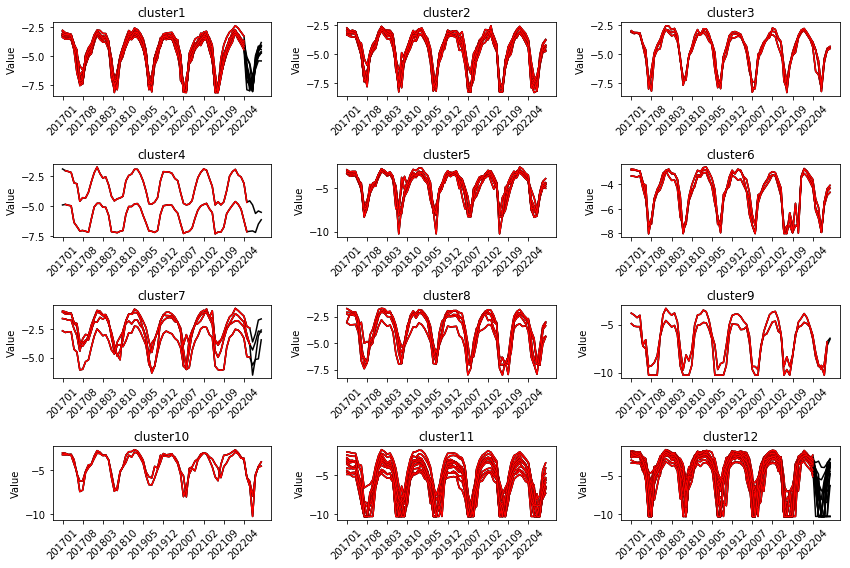

In [316]:
f3 = f2.set_index('KEY1').rename_axis(None)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8))

for i in range(n_rows * n_cols):
    data = pd.read_csv('results/energy_bicluster'+str(i+1)+'.csv', index_col = 0)
    data.index = data.index.map(lambda x: str(x).zfill(14)) 
    
    long_data = data.transpose()

    row = i // n_cols  # Calculate the row index
    col = i % n_cols # Calculate the column index
    
    ax = axes[row, col]  # Get the current axis

    # Plot lines in black
    
    ax.plot(f3[data.index], color='black')
    
    for column in long_data.columns:
        x_data = long_data.index
        y_data = long_data[column]
        
        ax.plot(x_data, y_data, color='black')

        mask = (x_data >= data.columns[0]) & (x_data <= data.columns[-1])

        # Create a new set of lines for the red segments within the date range
        ax.plot(x_data[mask], y_data[mask], color='red')

    ax.set_title('cluster' + str(i + 1))
    ax.set_ylabel('Value')

    # Adjust x-axis labels
    ax.set_xticks(ax.get_xticks()[::7])  # Display every 7th time point
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()  # Automatically adjust subplot parameters for better spacing
plt.show()  # Display the plot


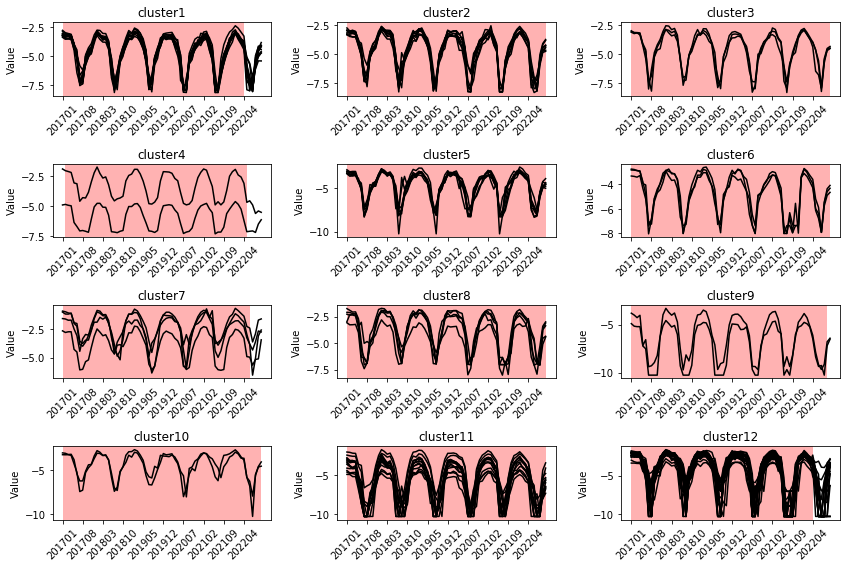

In [319]:
n_rows = 4  # Number of rows
n_cols = 3  # Number of columns

# Create a grid of subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 8))

for i in range(n):
    
    data = pd.read_csv('results/energy_bicluster'+str(i+1)+'.csv', index_col = 0)
    data.index = data.index.map(lambda x: str(x).zfill(14)) 
    
    long_data = data.transpose()

    row = i // n_cols  # Calculate the row index
    col = i % n_cols # Calculate the column index
    
    ax = axes[row, col]  # Get the current axis

    ax.plot(f3[data.index], color='black')
    ax.set_title('cluster'+str(i+1))
    ax.set_ylabel('Value')

    # Adjust x-axis labels
    ax.set_xticks(ax.get_xticks()[::7])  # Display every 7th time point
    ax.tick_params(axis='x', rotation=45)
    ax.axvspan(data.columns[0], data.columns[-1], facecolor='red', alpha=0.3)
    

plt.tight_layout()  # Automatically adjust subplot parameters for better spacing
plt.show()  # Display the plot

## Animation Example

In [97]:
def TD_CC_TSB(A, n, alpha, delta):
    # A is the data matrix, n=1 did nothing
    # alpha is in the paper, delta is just a small number.
    n_bicluster = []
    # the for loop need to be removed, since it did nothing. But it will the return data structure, which will impact 
    # the function residualScoreCol_add.
    for i in range (0, n):
        num_features = A.shape[0]
        num_time_points = A.shape[1]
        
        # I and J are the index holder of the data matrix.
        I = list(np.arange(0,num_features))
        J = list(np.arange(0,num_time_points))
        H = residualScore(A, I, J)
        print 'initial I list:', I
        print 'initial J list: J Start-', J[0], ' J end-',J[-1]
        #intial temp_H and H
        temp_H = 0
        H = 10000
        i_ = 0
        j = 0
        #print "deletion process"
        while abs(H - temp_H) > delta:
            print 
            print 'deletion process:', i_
            temp_H = H
            I = delelteRow(A, I, J, H, alpha)
            print 'I after delete rows', I 
            H = residualScore(A, I, J)
        
            #print "Hrow", H
            J = delelteCol(A, I, J, H, alpha)
            print 'J after delete columns: J Start-', J[0], ' J end-',J[-1]
            H = residualScore(A, I, J)
            print 'H socre after column deletion', H
            i_ += 1
            print 'Print H - temp_H:', abs(H - temp_H)
            #print "Hcol", H
        #print "Insertion process"
        insert = True
        while insert == True:
            print
            print 'insersion process:', j
            I_before = len(I)
            J_before = len(J)
            #print "rows before start insertion", I
            #print "columns before start insertion", J
            J = insertCol(A, I, J, H,alpha)
            print 'J after insert columns: J Start-', J[0], ' J end-',J[-1]
            H = residualScore(A, I, J)
            I = insertRow(A, I, J, H,alpha)
            print 'I after insert rows', I
            H = residualScore(A, I, J)
            I_after = len(I)
            J_after = len(J)
            #print "the length of rows after insertion", I_after
            #print "the length of columns after insertion", J_after
            if (I_before == I_after) and (J_before == J_after):
                insert = False
            j += 1
        # store the bicluster index
        print "final I", I
        print 'final J: J Start-', J[0], ' J end-',J[-1]
        n_bicluster.append([i, I, J])

    return n_bicluster


def delelteRow(A, I, J, H, alpha):
    for i in I:
        H_row = residualScoreRow_del(A, I, J, i)
        #print i, "row score", H_row
        ratio = 1./H*H_row
        #print "H score is", H
        #print "Ri ratio is", ratio
        if ratio > alpha:
            I.remove(i)
    #print "currently rows after deleting rows", I
    return I


def delelteCol(A, I, J, H, alpha):
    J_prime = [min(J), max(J)]
    for j in J_prime:
        H_col = residualScoreCol_del(A, I, J, j)
        ratio = 1./H*H_col
        #print j, "column socre", H_col
        #print "H score is", H
        #print "Rj ratio is", ratio
        if ratio > alpha:
            J.remove(j)
    #print "currently columns after deleting column",J
    return J

def insertCol(A, I, J, H,alpha):
    J_prime = [min(J)-1, max(J)+1]
    for j in J_prime:

        if (j >= A.shape[1]) or (j < 0):
            return J
        else:
            H_col = residualScoreCol_add(A, I, J, j)
            #print "column for insertion", j
            ratio = 1./H*H_col
            #print "column socore", H_col
            #print "Rj ration", ratio
            if ratio < alpha:
                J.append(j)
            #print "currently columns after inserting column",J
            return J


def insertRow(A, I, J, H,alpha):
    num_features = A.shape[0]
    full_I = list(np.arange(0,num_features))
    for i in full_I:
        if i not in I:
            H_row = residualScoreRow_add(A, I, J, i)
            ratio = 1./H*H_row
            #print i, "row score", H_row
            #print "Ri ratio", ratio
            if ratio < alpha:
                I.append(i)
    #print "currently rows after inserting rows",I
    return I



def residualScore(A, I, J):
    I.sort()
    J.sort()
    # get sub matrix based on index holder I(row) and J(column)
    sub_A = A[np.ix_(I,J)]
    # sub matrix mean
    a_I_J = sub_A.mean()
    temp = 0
    # loop the row of submatrix
    for i_sub in range (0, sub_A.shape[0]):
        a_i_J = sub_A.mean(1)[i_sub,0]
        # loop the column of the submatrix
        for j_sub in range(0, sub_A.shape[1]):
            a_i_j = sub_A[i_sub,j_sub]
            a_I_j = sub_A.mean(0)[0,j_sub]
            temp += (a_i_j - a_i_J - a_I_j + a_I_J)**2
    I_num = len(I)
    J_num = len(J)
    H = 1./(I_num*J_num)*temp
    return H


def residualScoreRow_del(A, I, J, i):
    I.sort()
    J.sort()
    # get row index of submatrix, which is the row i in full matrix
    i_sub = I.index(i)
    sub_A = A[np.ix_(I,J)]
    a_I_J = sub_A.mean()
    a_i_J = sub_A.mean(1)[i_sub,0]
    temp = 0
    for j_sub in range(0, len(J)):
        a_i_j = sub_A[i_sub,j_sub]
        a_I_j = sub_A.mean(0)[0,j_sub]
        temp += (a_i_j - a_i_J - a_I_j + a_I_J)**2
    J_num = len(J)
    H_row = 1./J_num*temp
    return H_row


def residualScoreCol_del(A, I, J, j):
    I.sort()
    J.sort()
    # get column index of submatrix, which is the column j in full matrix
    j_sub = J.index(j)
    sub_A = A[np.ix_(I,J)]
    a_I_J = sub_A.mean()
    a_I_j = sub_A.mean(0)[0,j_sub]
    temp = 0
    for i_sub in range (0, len(I)):
        a_i_J = sub_A.mean(1)[i_sub,0]
        a_i_j = sub_A[i_sub,j_sub]
        temp += (a_i_j - a_i_J - a_I_j + a_I_J)**2
    I_num = len(I)
    H_column = 1./(I_num)*temp

    return H_column

def residualScoreRow_add(A, I, J, i):
    I.sort()
    J.sort()
    i_sub = len(I)
    sub_A = A[np.ix_(I,J)]
    a_I_J = sub_A.mean()
    I_add = list(I)
    I_add.append(i)
    sub_A_add = A[np.ix_(I_add,J)]

    a_i_J = sub_A_add.mean(1)[i_sub,0]
    temp = 0
    for j_sub in range(0, len(J)):
        a_i_j = sub_A_add[i_sub,j_sub]
        a_I_j = sub_A.mean(0)[0,j_sub]
        temp += (a_i_j - a_i_J - a_I_j + a_I_J)**2
    J_num = len(J)
    H_row = 1./J_num*temp
    return H_row


def residualScoreCol_add(A, I, J, j):
    I.sort()
    J.sort()
    sub_A = A[np.ix_(I,J)]
    a_I_J = sub_A.mean()
    j_sub = len(J)
    J_add = list(J)
    J_add.append(j)
    sub_A_add = A[np.ix_(I,J_add)]
    a_I_j = sub_A_add.mean(0)[0,j_sub]
    temp = 0
    for i_sub in range (0, len(I)):
        a_i_J = sub_A.mean(1)[i_sub,0]
        a_i_j = sub_A_add[i_sub,j_sub]
        temp += (a_i_j - a_i_J - a_I_j + a_I_J)**2
    I_num = len(I)
    H_column = 1./(I_num)*temp

    return H_column

def bicluster_out(ret_tran, datatype = 'stock'):
    
    # filein is the file path and name. 
    # fileindate is the date read from stockdatelist. In this setup, it is easier to loop over all file with date as variable.
#     filein = 'stockreturn1min'+str(fileindate)+'.csv'
#     f = pd.read_csv (filein)
#     ret = f.drop(['date','time'], axis=1)
#     ret = ret.set_index('KEY1')
#     ret_tran = ret.transpose()
    
    A = ret_tran.values
    a = np.asmatrix(A)
    a1 = a.copy()
    num_stock_explained = 0
    # number of bicluster
    i = 0
    temp = 100
    # here is 80 is the beta in our paper
    while (num_stock_explained < 1):
        result = TD_CC_TSB(a1, 1, alpha= 1.2, delta= 1e-12)
        I = result[0][1]
        temp = len(I)
        num_stock_explained += temp
        J = result[0][2]

        # if there is new biclucter identified.
        if len(I) > 1:
            ff =ret_tran.iloc[I,J]
            ee = ret_tran.iloc[I,:]
            i += 1
            # output the identified new bicluster
#             outfile = str(fileindate)+'_'+'bicluster'+str(i)+'.csv'

            if datatype == 'stock':
                outfile = 'results/20130102_'+'bicluster'+str(i)+'.csv'
                
            if datatype == 'energy':
                outfile = 'results/energy_'+'bicluster'+str(i)+'.csv'
            
            ff.to_csv(outfile)
            
            # Eliminate all the identified biclusters from the orignal data matrix
            ret_tran = ret_tran[~ret_tran.isin(ee).all(1)]
            A = ret_tran.values
            a = np.asmatrix(A)
            a1 = a.copy()
        else:
            break
    return i, num_stock_explained

# read the date list
# tradingdayList_full = pd.read_csv ('stockdatelist.csv')
# tradingdayList_full = list(tradingdayList_full.date.unique())
# date_bicluster = []
# loop over the all the date
# bicluster_out('20130102_selected_as_example')
# for e in tradingdayList_full:
#     n, num = bicluster_out(e)
#     # record the date (e), the number of identifed biclusters (n), and the number of the stock explained (num)
#     date_bicluster.append([e, n, num])
    
# bic = pd.DataFrame(date_bicluster)
# # output the file recording the the date (e), the number of identifed biclusters (n), and the number of the stock explained (num)
# bic.to_csv('date_bicluster.csv')

In [98]:
# # read the date list
# tradingdayList_full = pd.read_csv ('stockdatelist.csv')
# tradingdayList_full = list(tradingdayList_full.date.unique())
# date_bicluster = []
# # loop over the all the date
# for e in tradingdayList_full:
#     n, num = bicluster_out(e)
#     # record the date (e), the number of identifed biclusters (n), and the number of the stock explained (num)
#     date_bicluster.append([e, n, num])
    
# bic = pd.DataFrame(date_bicluster)
# # output the file recording the the date (e), the number of identifed biclusters (n), and the number of the stock explained (num)
# bic.to_csv('date_bicluster.csv')


data_folder = 'data example/'
filein = data_folder + 'stockreturn1min' + '20130102' +'.csv'
f = pd.read_csv (filein)

ret = f.drop(['date','time'], axis=1)
ret = ret.set_index('KEY1')
ret_tran = ret.transpose()


# date_bicluster = []
# n, num = bicluster_out(ret_tran)
bicluster_out(ret_tran)
# record the date (e), the number of identifed biclusters (n), and the number of the stock explained (num)
# date_bicluster.append(['20130102', n, num])


initial I list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93]
initial J list: J Start- 0  J end- 388

deletion process: 0
I after delete rows [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93]
J after delete columns: J Start- 1  J end- 388
H socre after column deletion 0.0006169248163532591
Print H - temp_H: 9999.999383075183

deletion process: 1
I after delete

(1, 8)

In [37]:
len('ccccccccccc')

11

In [38]:
386-19

367

## Bicluster length

In [4]:
import pandas as pd
import numpy as np
import math

def TD_CC_TSB(A, n, alpha, delta):
    # A is the data matrix, n=1 did nothing
    # alpha is in the paper, delta is just a small number.
    n_bicluster = []
    # the for loop need to be removed, since it did nothing. But it will the return data structure, which will impact 
    # the function residualScoreCol_add.
    for i in range (0, n):
        num_features = A.shape[0]
        num_time_points = A.shape[1]
        
        # I and J are the index holder of the data matrix.
        I = list(np.arange(0,num_features))
        J = list(np.arange(0,num_time_points))
        H = residualScore(A, I, J)
        #intial temp_H and H
        temp_H = 0
        H = 10000
        #print "deletion process"
        while abs(H - temp_H) > delta:
            temp_H = H
            I = delelteRow(A, I, J, H, alpha)
            H = residualScore(A, I, J)
            #print "Hrow", H
            J = delelteCol(A, I, J, H, alpha)
            H = residualScore(A, I, J)
            
            #print "Hcol", H
        #print "Insertion process"
        insert = True
        while insert == True:
            I_before = len(I)
            J_before = len(J)
            #print "rows before start insertion", I
            #print "columns before start insertion", J
            J = insertCol(A, I, J, H,alpha)
            H = residualScore(A, I, J)
            I = insertRow(A, I, J, H,alpha)
            H = residualScore(A, I, J)
            I_after = len(I)
            J_after = len(J)
            #print "the length of rows after insertion", I_after
            #print "the length of columns after insertion", J_after
            if (I_before == I_after) and (J_before == J_after):
                insert = False

        # store the bicluster index
        n_bicluster.append([i, I, J])

    return n_bicluster


def delelteRow(A, I, J, H, alpha):
    for i in I:
        H_row = residualScoreRow_del(A, I, J, i)
        #print i, "row score", H_row
        ratio = 1./H*H_row
        #print "H score is", H
        #print "Ri ratio is", ratio
        if ratio > alpha:
            I.remove(i)
    #print "currently rows after deleting rows", I
    return I


def delelteCol(A, I, J, H, alpha):
    J_prime = [min(J), max(J)]
    for j in J_prime:
        H_col = residualScoreCol_del(A, I, J, j)
        ratio = 1./H*H_col
        #print j, "column socre", H_col
        #print "H score is", H
        #print "Rj ratio is", ratio
        if ratio > alpha:
            J.remove(j)
    #print "currently columns after deleting column",J
    return J

def insertCol(A, I, J, H,alpha):
    J_prime = [min(J)-1, max(J)+1]
    for j in J_prime:

        if (j >= A.shape[1]) or (j < 0):
            return J
        else:
            H_col = residualScoreCol_add(A, I, J, j)
            #print "column for insertion", j
            ratio = 1./H*H_col
            #print "column socore", H_col
            #print "Rj ration", ratio
            if ratio < alpha:
                J.append(j)
            #print "currently columns after inserting column",J
            return J


def insertRow(A, I, J, H,alpha):
    num_features = A.shape[0]
    full_I = list(np.arange(0,num_features))
    for i in full_I:
        if i not in I:
            H_row = residualScoreRow_add(A, I, J, i)
            ratio = 1./H*H_row
            #print i, "row score", H_row
            #print "Ri ratio", ratio
            if ratio < alpha:
                I.append(i)
    #print "currently rows after inserting rows",I
    return I



def residualScore(A, I, J):
    I.sort()
    J.sort()
    # get sub matrix based on index holder I(row) and J(column)
    sub_A = A[np.ix_(I,J)]
    # sub matrix mean
    a_I_J = sub_A.mean()
    temp = 0
    # loop the row of submatrix
    for i_sub in range (0, sub_A.shape[0]):
        a_i_J = sub_A.mean(1)[i_sub,0]
        # loop the column of the submatrix
        for j_sub in range(0, sub_A.shape[1]):
            a_i_j = sub_A[i_sub,j_sub]
            a_I_j = sub_A.mean(0)[0,j_sub]
            temp += (a_i_j - a_i_J - a_I_j + a_I_J)**2
    I_num = len(I)
    J_num = len(J)
    H = 1./(I_num*J_num)*temp
    return H


def residualScoreRow_del(A, I, J, i):
    I.sort()
    J.sort()
    # get row index of submatrix, which is the row i in full matrix
    i_sub = I.index(i)
    sub_A = A[np.ix_(I,J)]
    a_I_J = sub_A.mean()
    a_i_J = sub_A.mean(1)[i_sub,0]
    temp = 0
    for j_sub in range(0, len(J)):
        a_i_j = sub_A[i_sub,j_sub]
        a_I_j = sub_A.mean(0)[0,j_sub]
        temp += (a_i_j - a_i_J - a_I_j + a_I_J)**2
    J_num = len(J)
    H_row = 1./J_num*temp
    return H_row


def residualScoreCol_del(A, I, J, j):
    I.sort()
    J.sort()
    # get column index of submatrix, which is the column j in full matrix
    j_sub = J.index(j)
    sub_A = A[np.ix_(I,J)]
    a_I_J = sub_A.mean()
    a_I_j = sub_A.mean(0)[0,j_sub]
    temp = 0
    for i_sub in range (0, len(I)):
        a_i_J = sub_A.mean(1)[i_sub,0]
        a_i_j = sub_A[i_sub,j_sub]
        temp += (a_i_j - a_i_J - a_I_j + a_I_J)**2
    I_num = len(I)
    H_column = 1./(I_num)*temp

    return H_column

def residualScoreRow_add(A, I, J, i):
    I.sort()
    J.sort()
    i_sub = len(I)
    sub_A = A[np.ix_(I,J)]
    a_I_J = sub_A.mean()
    I_add = list(I)
    I_add.append(i)
    sub_A_add = A[np.ix_(I_add,J)]

    a_i_J = sub_A_add.mean(1)[i_sub,0]
    temp = 0
    for j_sub in range(0, len(J)):
        a_i_j = sub_A_add[i_sub,j_sub]
        a_I_j = sub_A.mean(0)[0,j_sub]
        temp += (a_i_j - a_i_J - a_I_j + a_I_J)**2
    J_num = len(J)
    H_row = 1./J_num*temp
    return H_row


def residualScoreCol_add(A, I, J, j):
    I.sort()
    J.sort()
    sub_A = A[np.ix_(I,J)]
    a_I_J = sub_A.mean()
    j_sub = len(J)
    J_add = list(J)
    J_add.append(j)
    sub_A_add = A[np.ix_(I,J_add)]
    a_I_j = sub_A_add.mean(0)[0,j_sub]
    temp = 0
    for i_sub in range (0, len(I)):
        a_i_J = sub_A.mean(1)[i_sub,0]
        a_i_j = sub_A_add[i_sub,j_sub]
        temp += (a_i_j - a_i_J - a_I_j + a_I_J)**2
    I_num = len(I)
    H_column = 1./(I_num)*temp

    return H_column

def bicluster_out(fileindate):
    
    # filein is the file path and name. 
    # fileindate is the date read from stockdatelist. In this setup, it is easier to loop over all file with date as variable.
    filein = 'cleanprice_1min/stockreturn1min'+str(fileindate)+'.csv'
    f = pd.read_csv (filein)
    ret = f.drop(['date','time'], axis=1)
    ret = ret.set_index('KEY1')
    ret_tran = ret.transpose()
    A = ret_tran.values
    a = np.asmatrix(A)
    a1 = a.copy()
    num_stock_explained = 0
    # number of bicluster
    i = 0
    temp = 100
    # here is 80 is the beta in our paper
    while (num_stock_explained < 80):
        result = TD_CC_TSB(a1, 1, alpha= 1.2, delta= 1e-12)
        I = result[0][1]
        temp = len(I)
        num_stock_explained += temp
        J = result[0][2]

        # if there is new biclucter identified.
        if len(I) > 1:
            ff =ret_tran.iloc[I,J]
            ee = ret_tran.iloc[I,:]
            i += 1
            # output the identified new bicluster
            outfile = 'biclusterresult/'+str(fileindate)+'_'+'bicluster'+str(i)+'.csv'
            ff.to_csv(outfile)
            
            # Eliminate all the identified biclusters from the orignal data matrix
            ret_tran = ret_tran[~ret_tran.isin(ee).all(1)]
            A = ret_tran.values
            a = np.asmatrix(A)
            a1 = a.copy()
        else:
            break
    return i, num_stock_explained

# read the date list
tradingdayList_full = pd.read_csv ('cleanprice_1min/stockdatelist.csv')
tradingdayList_full = list(tradingdayList_full.date.unique())
date_bicluster = []
# loop over the all the date
for e in tradingdayList_full:
    n, num = bicluster_out(e)
    # record the date (e), the number of identifed biclusters (n), and the number of the stock explained (num)
    date_bicluster.append([e, n, num])
    
bic = pd.DataFrame(date_bicluster)
# output the file recording the the date (e), the number of identifed biclusters (n), and the number of the stock explained (num)
bic.to_csv('biclusterresult/date_bicluster.csv')


In [11]:
data_bicluster = bic.values

In [12]:
data_bicluster[0]

array([20130102,        9,       80])

In [31]:
shape = []
leng = []
j=0
n =0
for elm in data_bicluster:
    bi = elm[1]
    date = elm[0]
    #print(date)
    for i in range(1,bi+1):
        filein = 'biclusterresult/'+str(date)+'_'+'bicluster'+str(i)+'.csv'
        f = pd.read_csv (filein)
        shape.append(f.shape)
        leng.append(f.shape[1]-1)
        n += (f.shape[1]-1)
        j += 1
average = n/j
print('Average Length is ', average)
print('Max length is ', max(leng))
print('Min length is ', min(leng))

('Average Length is ', 365)
('Max length is ', 389)
('Min length is ', 289)


In [32]:
ss = pd.DataFrame(shape)

In [33]:
ss.columns=['Rows', 'Columns']

In [34]:
ss.to_csv("biclusterresult/bicluster size.csv", index=False)